In [1]:
import scipy as sp
from pylab import *
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import seaborn as sns
import collections
from IPython.display import clear_output
import random
import json

import pandas as pd # seaborn violin plots
import scipy.stats as st # stat tests
import re # split by tabs using regex
import joblib as jl
    # parallel coffee gets stupid things done faster with more energy
sns.set_style("darkgrid") # make pwetty plots
# colorblind colors
cb_palette = ["#777777", "#E69F00", "#56B4E9", "#009E73",
              "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
    # http://www.cookbook-r.com/Graphs/Colors_(ggplot2)/#a-colorblind-friendly-palette
    # http://jfly.iam.u-tokyo.ac.jp/color/
matplotlib.rcParams.update({'font.size': 22}) # bigger text

In [2]:
dat = pd.read_csv('plasmodium_interactome.csv') # import main data from paper

In [3]:
dat.head()

,source,sourceDescription,target,targetDescription,RFscore,STRING,REACTOME,PbONE,PbPOINT,PbZERO,...,Phn,Shared.max.peaks,Pbonly,Pfonly,Pkonly,map,worm,yeast,human,fly
0,PF3D7_0102900,aspartate--tRNA ligase,PKNH_1441400,"endoplasmin, putative",0.934,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,Y,OG5_126623|OG5_127227,NaN,NaN,NaN,NaN
1,PF3D7_0102900,aspartate--tRNA ligase,PKNH_1030600,"merozoite surface protein 3, putative",0.950,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Y,OG5_127227|OG5_162796,NaN,NaN,NaN,NaN
2,PF3D7_0102900,aspartate--tRNA ligase,PKNH_0600600,"Plasmodium exported protein (PHIST), unknown f...",0.986,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Y,OG5_127227|OG5_176625,NaN,NaN,NaN,NaN
3,PF3D7_0102900,aspartate--tRNA ligase,PF3D7_1138800,"WD repeat-containing protein, putative",0.966,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Y,NaN,OG5_127227|OG5_150004,NaN,NaN,NaN,NaN
4,PF3D7_0102900,aspartate--tRNA ligase,PF3D7_0826500,"ubiquitin conjugation factor E4 B, putative",0.924,NaN,NaN,NaN,0.581075,0.671321,...,NaN,3.0,NaN,NaN,NaN,OG5_127227|OG5_128694,NaN,NaN,NaN,NaN


In [4]:
# Now we keep only what we'll feed into networkx format
d = dat["source"] +" "+ dat["target"] + " {'weight':" + dat['X.times.seen'].astype(str) + "}"
G = nx.parse_edgelist(d) # creates a networkx graph

In [5]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1761
Number of edges: 26060
Average degree:  29.5968


In [6]:
# These take a while to compute
kamada_kawai_layout_pos = nx.kamada_kawai_layout(G)
spring_layout_pos = nx.spring_layout(G)

In [7]:
circular_layout_pos = nx.circular_layout(G)
spectral_layout_pos = nx.spectral_layout(G)

/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


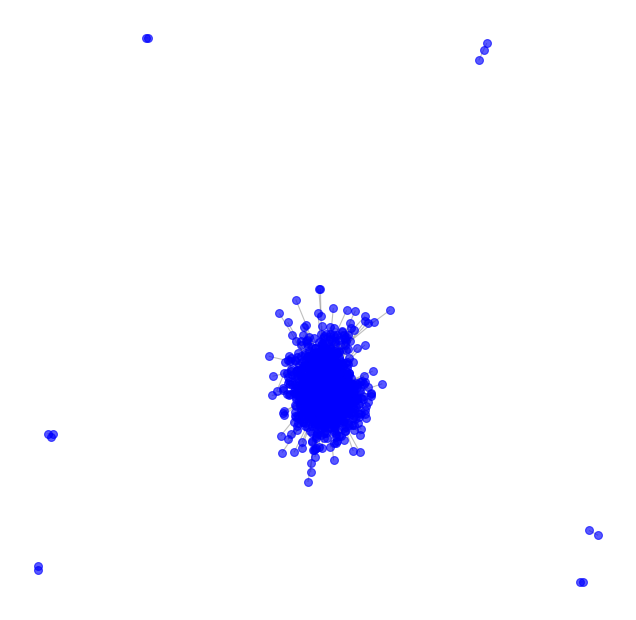

In [8]:
# Make a nice big figure that you can export later for your report: 
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')

# generate the positions of the features of the graph using some layout from networkx (https://networkx.github.io/documentation/networkx-1.10/reference/drawing.html)
pos = nx.spring_layout(G)

# remove the unnecessary axes
plt.axis('off')

# draw the nodes - choose nice set of aesthetic properties to make them look fancy
nx.draw_networkx_nodes(G,pos,alpha=0.65,node_size=50,node_color='blue')

# draw the edges - choose nice set of aesthetic properties to make them look fancy
nx.draw_networkx_edges(G,pos,alpha=0.5,edge_color='gray')

# fingers crossed!
plt.show()

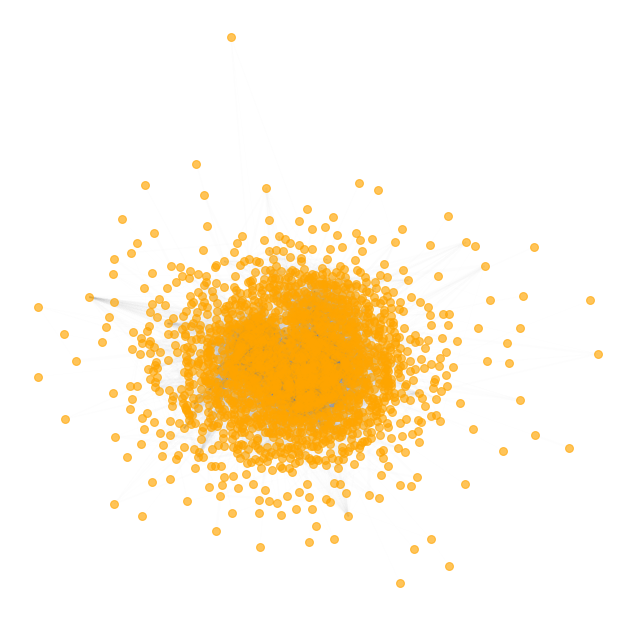

In [9]:
# Make a nice big figure that you can export later for your report: 
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')

# generate the positions of the features of the graph using some layout from networkx (https://networkx.github.io/documentation/networkx-1.10/reference/drawing.html)
pos = kamada_kawai_layout_pos

# remove the unnecessary axes
plt.axis('off')

# draw the nodes - choose nice set of aesthetic properties to make them look fancy
nx.draw_networkx_nodes(G,pos,alpha=0.65,node_size=50,node_color='orange')

# draw the edges - choose nice set of aesthetic properties to make them look fancy
nx.draw_networkx_edges(G,pos,alpha=0.01,width=dat['X.times.seen']*3/dat['X.times.seen'].max(),edge_color='gray')

# fingers crossed!
plt.show()

In [10]:
# I was considering weighing edges according to number of times seen but that craps out sigma JS's renderer
dat['X.times.seen'].max()

9

In [11]:
# We need a table to look up gene IDs and match them to descriptions
lookup_table = dat[['source','sourceDescription']]
print(lookup_table.shape)
lookup_table.head()

(26060, 2)


,source,sourceDescription
0,PF3D7_0102900,aspartate--tRNA ligase
1,PF3D7_0102900,aspartate--tRNA ligase
2,PF3D7_0102900,aspartate--tRNA ligase
3,PF3D7_0102900,aspartate--tRNA ligase
4,PF3D7_0102900,aspartate--tRNA ligase


In [12]:
# a second table from the targets column, we'll now combine the two
lookup_table2 = dat[['target','targetDescription']]
lookup_table2.columns = lookup_table.columns
print(lookup_table2.shape)
lookup_table2.head()

(26060, 2)


,source,sourceDescription
0,PKNH_1441400,"endoplasmin, putative"
1,PKNH_1030600,"merozoite surface protein 3, putative"
2,PKNH_0600600,"Plasmodium exported protein (PHIST), unknown f..."
3,PF3D7_1138800,"WD repeat-containing protein, putative"
4,PF3D7_0826500,"ubiquitin conjugation factor E4 B, putative"


In [13]:
# We combine both lookup tables to get a single index of gene IDs and descriptions
lookup_table = lookup_table.append(lookup_table2)
print(lookup_table.shape)
lookup_table.head()

(52120, 2)


,source,sourceDescription
0,PF3D7_0102900,aspartate--tRNA ligase
1,PF3D7_0102900,aspartate--tRNA ligase
2,PF3D7_0102900,aspartate--tRNA ligase
3,PF3D7_0102900,aspartate--tRNA ligase
4,PF3D7_0102900,aspartate--tRNA ligase


In [14]:
print(lookup_table.loc[lookup_table['source'] == 'PF3D7_1137400'])

              source                      sourceDescription
93     PF3D7_1137400  UVB-resistance protein UVR8 homologue
14810  PF3D7_1137400  UVB-resistance protein UVR8 homologue
19521  PF3D7_1137400  UVB-resistance protein UVR8 homologue


In [15]:
# Finally, we want to assign these gene IDs to the clusters reported by Hillier et al.
# We read the data file with the clusters
clu = pd.read_csv('clusters.csv')
clu = dict(zip(clu['GeneID'],clu['Cluster#'])) 
    # make dict from df with gene ID as key and cluster number as value

for gene in lookup_table['source']: # for every gene ID in our lookup table
    if gene not in clu.keys(): # if no cluster assigned
        clu[gene] = 0 # add to dictionary as coresponding to (fake) cluster zero
        

# We generate a palette of colors corresponding to clusters, using seaborn's default color palette of 10 colors
# We add black as the color of cluster zero
pal = [(0,0,0)] + sns.color_palette(None,max(clu.values())) 

# For truly distinct colors for each cluster, we could've used a cubehelix palette,
# but this was actually hard to discern:
# cubehelix_palette(max(clu.values()), start=2, rot=2, dark=0.1, light=.9, )

In [16]:
# Now we need to construct a json file to be read by sigma.js with all this info
# adapted from 

nodes = [
    {
        "id": str(i),
        "label": str(i)+': '+str(lookup_table.loc[lookup_table['source'] == i,'sourceDescription'].reset_index(drop=True)[0]),
        "color": "rgba" + str( tuple( (np.array( pal[clu[i]] ) * 255).astype('int') ) + (1,) ) + "",
        "x": int(pos[i][0] * 256),
        "y": int(pos[i][1] * 256),
        "size": 0.01,
        "cluster":clu[i]
    }
    for ni, i in enumerate(G.nodes())
]
links = [
    {
        "id": str(ui),
        "source": u[0],
        "target": u[1]#,
        # Setting alpha to correspond to the number of times seen does not sit well with sigma.js:
        #"color": "rgba(0,0,0," + str(round(item["weight"]/dat['X.times.seen'].max(), 2)) + ")",
    }
    for ui, (u, item) in enumerate(G.edges.items())
]

graph_data = {"nodes": nodes, "edges": links}

with open('../dat/plasmodium_interactome.json', 'w') as f:
    json.dump(graph_data,
              f, indent=4,)